# Tabu Search
Tabu ("taboo") search algorithm is based on the idea that you want to prevent the search from going back to some regions. This forces the algorithm to exploit the search space. It is most commonly used to solve combinatorial (finite solution set) optimization problems. To apply Tabu search, a dynamic neighbourhood search algorithm needs to be implemented first. Tabu search has the following 3 main strategies:

1. Fobidding strategy: controls what enters the Tabu list
2. Freeing Strategy: controls what exists the Tabu list
3. Short-term strategy: manages interplay between the forbidding strategy and freeing strategy to select trial solutions.

## Basic Elements of Tabu Search
* **Memory** is exploited by classifying a subset of moves in a neighbourhood as **forbidden** (or *tabu*).
    * This classification depends upon the search history and on the frequency that certain move (called attributes) have participated in generating past solutions.
    * **Tabu tenure** is the numbe rof iterations for which a move is considered to be tabu.
* A **neighbourhood** is constrcted ot identify adjacent solutions that can be reached from current solution.
* The **Aspiration Criterion** provides exception to Tabu restrictions. When a tabu move has *sufficiently attractive* evaluation (better than any other move visited so far, then its tabu classification may be overridden).

## Basic algorithm
1. Choose initial solution $i\in S$. Set $i^* = i$ and $k=0$
2. Set $k = k+1$ and generate a subset $V^*\in N(i, k)$ where $N(i,k)$ is the neighbourhood such that either one of the Tabu conditions is violated or atleast one of the aspiration conditions holds.
3. Choose a best $j\in V^*$ and set $i=j$
4. If $f(i)<f(i^*)$ then set $i^*=i$
5. Update Tabu and aspiration conditions
6. If stopping condition met, then end. Else goto 2.

Some possible stopping criterion could be:
* $N(i, k+1)=\phi$ (no feasible solution in the neighbourhood of solution $i$)
* $k$ is larger than the maximum numebr of allowed iterations
* The number of iterations since the last improvement in $i^*$ is greater than a specified number
* Some evidence avaialbe that optimum solution has been reached.

## Advantages and Disadvatnages of Tabu Search
**Advantages:**
* Allows escaping the local optimum by accepting non-improving solution.
* Can be applied to both discrete and continuous solution space.
* Can be used for complex problems on scheduling, quadratic assignemtn and vehicle routing. Obtains competitive solutions when compared to other approaches.

**Disadvantages:**
* Too many parameteres to be determined
* Number of iterations can be large
* Like all heuristic methods, the global minimum is not guaranteed.

## Data structure for holding Tabu information
For examples in which there is pair switching (example the travelling salesman problem), the Tabu structure can be maintained by using a triangular table where the element $T(i,j)$ denotes the number of iterations for which transition between solution $i$ and solution $j$ is tabu.

To show some implementations of Tabu Search, we will be looking at two problems: the travelling salesman problem (similar ot the one explored in `4. Genetic Algorithms Examples.ipynb`), and the vehicle routing problem.

## Tabu Search for Travelling Salesman Problem
The travelling salesman problem (TSP), as mentioned before is a problem where given a random set of cities, and a starting city, the aim of the saleman is to figure out the optimal path such that all cities are visited (compleeting the loop back to the startin city) by travelling the least amount of distance.

In [1]:
import numpy as np
from random import randint
from itertools import combinations
from matplotlib import pyplot as plt

In [2]:
class TravelSalesPerson(object):
    def __init__(self, n_cities, max_coor = 1):
        self.city_position = np.random.rand(n_cities, 2)*max_coor
        self.iter = 0
        self.n_cities = n_cities
        self.max_coor = max_coor

    def cost(self, visit_order):
        '''Calculates the total distance travelled when visiting the cities in the order provided.
        :param visit_order: (Nxd) matrix of N possible permutations of d cities
        :return dist: (1xN) vector of total distances travelled for each permutation 
        '''
        if visit_order.shape[1] != self.n_cities:
            raise Exception("visit_order should have dim[1] = number of cities")
        dist = np.zeros(visit_order.shape[0])
        for i in range(self.n_cities-1):
            dist += np.linalg.norm(self.city_position[visit_order[:, i], :] - self.city_position[visit_order[:, i+1], :], axis=1)

        dist += np.linalg.norm(self.city_position[visit_order[:, -1], :] - self.city_position[visit_order[:, 0], :], axis=1)
        return dist

    def plotting(self, order, cost, save=False):
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        lx, ly = self.city_position[order, 0], self.city_position[order, 1]
        plt.plot(lx.T, ly.T, 'r-')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % cost, fontdict={'size': 20, 'color': 'red'})
        # plt.xlim((-0.1, 1.1))
        # plt.ylim((-0.1, 1.1))
        if save: plt.savefig('Images/travelling_salesman/travelling_salesman_{:03d}'.format(self.iter))
        if self.iter%100==0: plt.show()
        self.iter += 1

In [13]:
class Tabu_TSP():
    def __init__(self, tsp, tabu_tenure=3, n_neighbors=10, neighbour_method='basic', max_iter=500):
        '''
        :param tsp: TSP problem of class TravelSalesPerson
        :param tabu_tenure: no. of iterations for which move is Tabu
        :param n_neighbors: Number of neighbours to consider at every iteration
        :param neighbour_method: Method used to calculate neighbours
        :param max_iter: Maximum number of iterations allowed for Tabu Search
        '''
        if neighbour_method not in ['basic', 'two_opt']:
            raise Exception("neighnour_method must be one of 'basic', 'two_opt'")
        self.tsp = tsp
        self.tt = tabu_tenure
        self.n_neigh = n_neighbors
        self.get_neighbours = self.basic if neighbour_method=='basic' else self.two_opt_swap
        self.tabu_list = np.zeros((self.tsp.n_cities, self.tsp.n_cities), dtype=np.int)
        self.max_iter = max_iter
        self.draw = False

    def basic(self, order):
        '''
        Perform random swap of 2 citites to get n_neigh neighbors.
        :param order: intial order for which the negighbors are found
        :returns neighborhood: (Nxd) numpy matrix of N neighbors, of each length d cities
        :returns swap_ids: (Nx2) numpy matrix of ids swapped for each of the N neighbours
        '''
        # get n_neigh number of random swaps on citites
        combs = np.array(list(combinations(np.arange(1, len(order), dtype=np.int), 2)))
        sample = np.random.randint(len(combs), size=self.n_neigh)
        swap_ids = combs[sample]
        neighbors = np.tile(order, (self.n_neigh, 1))

        # swap indices
        n_aranged = np.arange(self.n_neigh)
        temp = neighbors[n_aranged, swap_ids[:, 0]]
        neighbors[n_aranged, swap_ids[:, 0]] = neighbors[n_aranged, swap_ids[:, 1]]
        neighbors[n_aranged, swap_ids[:, 1]] = temp
        return neighbors, swap_ids

    def two_opt_swap(self, order):
        '''
        Perform stochastic two-opt swap to get n_neigh neighbors.
        :param order: intial order for which the negighbors are found
        :returns neighborhood: (Nxd) numpy matrix of N neighbors, of each length d cities
        :returns swap_ids: (Nx2) numpy matrix of ids swapped for each of the N neighbours
        '''
        # get n_neigh number of random swaps on citites
        combs = np.array(list(combinations(np.arange(1, len(order), dtype=np.int), 2)))
        sample = np.random.randint(len(combs), size=self.n_neigh)
        swap_ids = combs[sample]
        neighbors = np.empty((self.n_neigh, len(order)), dtype=np.int)

        # swap indices
        for i, (n1, n2) in enumerate(swap_ids):
            neighbors[i] = np.concatenate((order[:n1], order[n1:n2][::-1], order[n2:]))
        
        return neighbors, swap_ids

    def run(self, initial_solution=None):
        '''
        Run the Tabu search.
        :param initial_solution: Optional initial solution to start the search.
        :returns best_sol: Best permutation of cities found
        :returns best_cost: Cost of the best permutation found
        '''
        # Initialize
        if initial_solution is None:
            best_sol = np.arange(self.tsp.n_cities, dtype=np.int)
            np.random.shuffle(best_sol[1:])
            curr_sol = best_sol
        else:
            best_sol = initial_solution
            curr_sol = best_sol
        best_cost = self.tsp.cost(np.expand_dims(best_sol, axis=0))[0]
        curr_cost = best_cost
        iter_num = 0

        while iter_num < self.max_iter:
            neighborhood, swap_ids = self.get_neighbours(curr_sol)
            neighborhood_costs = self.tsp.cost(neighborhood)
            neigh_ordered_id = np.argsort(neighborhood_costs)
            found = False
            idx = 0

            while not found:
                id2check = neigh_ordered_id[idx]
                if self.tabu_list[tuple(swap_ids[id2check, :])] == 0 \
                    or neighborhood_costs[id2check] < best_cost:   #best move is not tabu -> proceed OR aspiration criteria passed
                    curr_sol = neighborhood[id2check, :]
                    curr_cost = neighborhood_costs[id2check]
                    self.tabu_list[self.tabu_list>0] -= 1
                    self.tabu_list[tuple(swap_ids[id2check, :])] = self.tt
                    if curr_cost < best_cost:
                        best_sol = curr_sol
                        best_cost = curr_cost
                    found = True
                else:
                    idx += 1
                    if idx >= self.n_neigh:
                        print("No neighbours pass Aspiration Criterion. Getting new neighbors...")
                        break
            if self.draw: self.tsp.plotting(best_sol, best_cost)
            iter_num += 1
        return best_sol, best_cost

    def visualize(self):
        self.draw = True
        self.run()


Starting Tabu Search with initial cost:  4.665817225861911


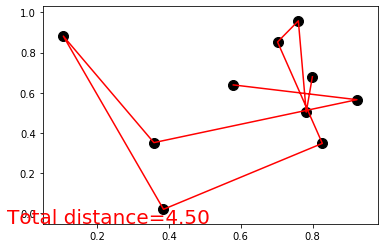

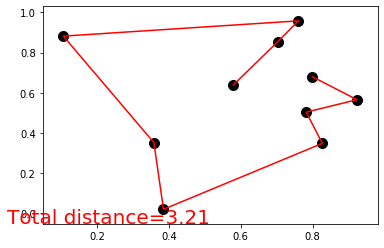

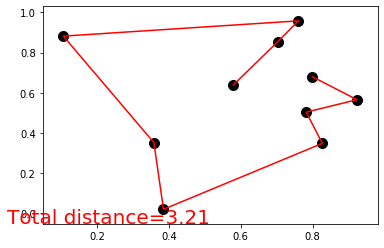

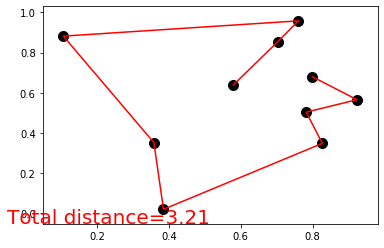

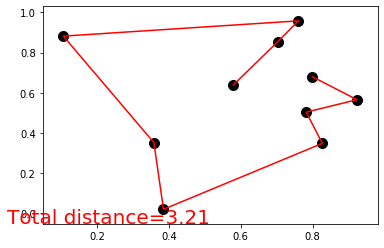

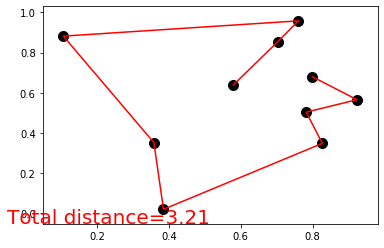

In [9]:
tsp = TravelSalesPerson(10)
tabu_search = Tabu_TSP(tsp, n_neighbors=5, tabu_tenure=1 ,neighbour_method='two_opt')
tabu_search.visualize()

Now that we have implemented the Tabu search for TSP, let's compare the two neighborhood search strategies: `basic` and `two_opt`:

Text(0, 0.5, 'Final solution cost')

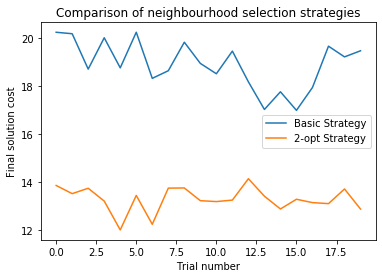

In [15]:
n_trials = 20
best_basic = []
best_two_opt = []
for _ in range(n_trials):
    tsp = TravelSalesPerson(n_cities=100)
    tabu_basic = Tabu_TSP(tsp, tabu_tenure=5, n_neighbors=20)
    tabu_2opt = Tabu_TSP(tsp, tabu_tenure=5, n_neighbors=20, neighbour_method='two_opt')
    init_sl = np.arange(tsp.n_cities, dtype=np.int)
    np.random.shuffle(init_sl[1:])
    _, basic_cost = tabu_basic.run(initial_solution=init_sl)
    _, opt_cost = tabu_2opt.run(initial_solution=init_sl)
    best_basic.append(basic_cost)
    best_two_opt.append(opt_cost)

plt.plot(np.arange(n_trials), best_basic)
plt.plot(np.arange(n_trials), best_two_opt)
plt.legend(['Basic Strategy', '2-opt Strategy'])
plt.title('Comparison of neighbourhood selection strategies')
plt.xlabel('Trial number')
plt.ylabel('Final solution cost')

## (Capacitated) Vehicle Routing Problem
The [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem)(VRP) is a generalization of the Travelling Salesman Problem which asks the question: "What is the optimal set of routes for a fleet of vehicles to traverse in order to deliver to a given set of customers?" The Capacitated VRP is a variant of the VRP where each vehicles can only carry a maximum capacity of $Q$. The problem can be formally defined using a graph $G = (V,E)$ with a set of vertices $V$ and edges $E$. Vertex $v_0\in V$ is the **depot**, or the source of goods to be delivered. All other vertices $v_{i\neq 0}\in V$ are the customers to which the goods need to be delivered. Each $v_{i\neq 0}$ is associated with a $q_i$ which is the quantity of the goods requested by the $i$th customer. The edges $e_{ij}\in E$ is weighted with the cost $c_{ij}$ of travelling between the two vertices. The optimal set of routes has the following characteristics:
* The start and end of each route is the depot vertex.
* Each customer is visited exactly once by only one of the routes.
* The total number of goods carried by the vehicles does not exceed $Q$.
* The total cost of transporting the goods is minimized.

The implementation below is adapted (with some trivial changes) from [afurculita's solution in Java](https://github.com/afurculita/VehicleRoutingProblem). The original code implements a Greedy search algorithm as well, which is then used as an intializatin for the Tabu search. I also added a random initialization to see how much benefit does doing the greedy search first accrues. This is importatnt because even doing the greedy search takes some computation. In the random initialization, beginning with the first vehicle, random customers are added until no more customers can be added due to the quantity constraint. This is continued until all customers are catered to.

The Tabu search takes place as follows:

* **Neighborhood definition:** For every pair of vehicles $v_a$ and $v_b$, and for all node pairs $(n_i, n_j) s.t. n_i\in v_a, n_j\in v_b$, we remove the node $n_i$ from $v_a$ and insert it after $n_j$ in $v_b$. Therfore, after the change we have:

  $v_a: \ldots\to n_{i-1}\to n_{i+1}\to\ldots$

  $v_b: \ldots\to n_{j-1}\to n_j \to n_i \to n_{j+1} \to\ldots$
* **Tabu Constraint:** A move that fulfills even one of the following conditions is considered Tabu:

  $T[n_{i-1}\to n_{i+1}] > 0$

  $T[n_j\to n_i] > 0$

  $T[n_i\to n_{j+1}] > 0$

In [2]:
from third_party.VRP.read_vrp import read_input_cvrp # to read CVRP problem files
from third_party.VRP.cvrp_afurculita import Node, Vehicle, Greedy_VRP
import math

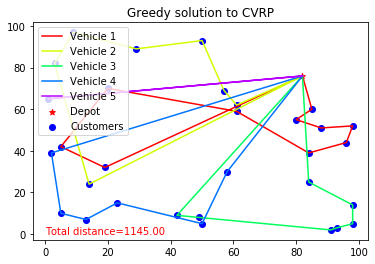

In [3]:
greedy_vrp = Greedy_VRP('data\VRP\A-n32-k5.vrp', n_vehicles=10)
greedy_vrp.run()
greedy_vrp.plot()

In [4]:
class Tabu_VRP():
    def __init__(self, vrp_file, n_vehicles=None, tabu_tenure=5, initialize=None, max_iter_without_improvement=20):
        '''
        Class responsible for running Tabu search on a Capacitated Vehicle Rouitnig Problem.
        :param vrp_file: Path to .vrp file that describes the CVRP problem
        :param n_vehicles: maximum number of vehicles avaiable. Default n_vehciles=number of customers (upper bound)
        :param tabu_tenure: no. of moves for which move is tabu (a random int between [0,5) is added for every element)
        :param initialize: Method used to initialize solution. One of ['random', 'greedy']. If greedy, greedy optimization is run first
        :param max_iter_without_improvement: stopping criteria. If no improvement after these many turns, algorithm stops.
        :returns vehicles: list of class Vehicle indicating the optimal solution found
        :returns cost: minimum cost of the optimal solution found
        '''
        self.n_cust, self.cust_locations, Q, self.dist_matrix, self.dist_warehouse, demands = read_input_cvrp(vrp_file)
        if n_vehicles is None: n_vehicles = self.n_cust
        self.vehicles = [Vehicle(Q) for _ in range(n_vehicles)]
        self.nodes = [Node(i, demands[i]) for i in range(self.n_cust)]
        self.max_iter = max_iter_without_improvement
        self.tt = tabu_tenure
        self.finished = False

        if initialize in [None, 'random']:
            self.random_init()
        elif initialize is 'greedy':
            greedy_vrp = Greedy_VRP(vrp_file, n_vehicles)
            self.vehicles, self.cost = greedy_vrp.run()
            self.n_vehicles = greedy_vrp.n_vehicles
        else:
            raise Exception("initialize must be one of ['random', 'greedy']")

        self.best_sol = [Vehicle(Q) for _ in range(n_vehicles)]
        self.updateBestSolution()

    def updateBestSolution(self):
        '''
        Takes the current value of self.vehicles and copies it int self.best_sol
        '''
        self.best_cost = self.cost
        for v_id in range(self.n_vehicles):
            self.best_sol[v_id].nodes = []
            n_nodes = len(self.vehicles[v_id].nodes)
            if n_nodes != 0:
                for i in range(n_nodes):
                    self.best_sol[v_id].addNode(self.vehicles[v_id].nodes[i])
        return

    def random_init(self):
        '''
        Randomly assigns customers to a vehicle until vehicle cannot accept anymore due to quantity constraint
        '''
        cust_assigned = np.zeros(self.n_cust, dtype=bool)
        vehicle_id = 0
        self.cost = 0
        while not all(cust_assigned):
            node_id = np.random.choice(self.n_cust, p=(~cust_assigned/sum(~cust_assigned)))
            if len(self.vehicles[vehicle_id].nodes) == 0:
                self.vehicles[vehicle_id].addNode(self.nodes[0])
                cust_assigned[0] = True

            if self.vehicles[vehicle_id].checkConstraint(self.nodes[node_id].demand):
                self.cost += self.dist_matrix[self.vehicles[vehicle_id].nodes[-1].id, node_id]
                self.vehicles[vehicle_id].addNode(self.nodes[node_id])
                cust_assigned[node_id] = True
            else:
                self.cost += self.dist_matrix[self.vehicles[vehicle_id].nodes[-1].id, 0]
                self.vehicles[vehicle_id].addNode(self.nodes[0])
                vehicle_id += 1
                if vehicle_id >= len(self.vehicles):
                    raise Exception("Could not randomly initialize problem. Ran out of vehicles, with customers still remaining...")

        self.cost += self.dist_matrix[self.vehicles[vehicle_id].nodes[-1].id, 0]
        self.vehicles[vehicle_id].addNode(self.nodes[0])
        self.n_vehicles = vehicle_id+1
        return

    def run(self):
        '''
        Raun the Tabu search algorithm
        '''
        nodesFrom, nodesTo = [], []
        movingNodeDemand = 0
        swapIdA, swapIdB, swapNodeFrom, swapNodeTo = -1, -1, -1, -1
        n_iter = 0
        tabu_matrix = np.zeros((self.n_cust+1, self.n_cust+1), dtype=np.int)

        while n_iter < self.max_iter:
            bestNCost = math.inf
            ##SEARCH FOR BEST MOVE
            for vIdFrom in range(len(self.vehicles)):
                nodesFrom = self.vehicles[vIdFrom].nodes
                n_nodesFrom = len(nodesFrom)
                for i in range(1, n_nodesFrom-1):   # We cannot move the depot (1st and last)
                    for vIdTo in range(len(self.vehicles)):
                        nodesTo = self.vehicles[vIdTo].nodes
                        n_nodesTo = len(nodesTo)
                        for j in range(0, n_nodesTo-1): # We cannot insert after last depot
                            movingNodeDemand = nodesFrom[i].demand

                            if vIdFrom==vIdTo or self.vehicles[vIdTo].checkConstraint(movingNodeDemand):
                                # If moving within the same vehicle, no need to check for constraint
                                # If moving between different vehicles, need to check for constraint
                                if not (vIdFrom == vIdTo and (j==i or j==i-1)):
                                    # Only continue for moves that change the overall cost
                                    #Check if the move is Tabu:
                                    if any(tabu_matrix[[nodesFrom[i-1].id, nodesTo[j].id, nodesFrom[i].id], [nodesFrom[i+1].id, nodesFrom[i].id, nodesTo[j+1].id]] != 0): break
                                    
                                    # below calculates the cost associated with the following changes:
                                    # vIdFrom: ... -> i-1 -> i+1 -> ...
                                    # vIdTo: ... -> j-1 -> j -> i -> j+1 -> ...
                                    minus = self.dist_matrix[[nodesFrom[i-1].id, nodesFrom[i].id, nodesTo[j].id], [nodesFrom[i].id, nodesFrom[i+1].id, nodesTo[j+1].id]]
                                    add = self.dist_matrix[[nodesFrom[i-1].id, nodesTo[j].id, nodesFrom[i].id], [nodesFrom[i+1].id, nodesFrom[i].id, nodesTo[j+1].id]]
                                    neighbor_cost = sum(add) - sum(minus)
                                    if neighbor_cost < bestNCost:
                                        bestNCost = neighbor_cost
                                        swapIdA, swapIdB = i, j
                                        swapNodeFrom, swapNodeTo = vIdFrom, vIdTo
            
            ## UPDATE TABU MATRIX
            tabu_matrix[tabu_matrix>0] -= 1
            nodesFrom = self.vehicles[swapNodeFrom].nodes
            nodesTo = self.vehicles[swapNodeTo].nodes

            swapNode = nodesFrom[swapIdA]
            tabu_matrix[[nodesFrom[swapIdA-1].id, swapNode.id, nodesTo[swapIdB].id], [swapNode.id, nodesFrom[swapIdA+1].id, nodesTo[swapIdB+1].id]] = self.tt + np.random.randint(0, 5, size=3)
            nodesFrom.pop(swapIdA)

            ## UPDATE VEHICLES
            if swapNodeFrom == swapNodeTo:
                if swapIdA < swapIdB:
                    nodesTo.insert(swapIdB, swapNode)
                else:
                    nodesTo.insert(swapIdB+1, swapNode)
            else:
                nodesTo.insert(swapIdB+1, swapNode)

            self.vehicles[swapNodeFrom].nodes = nodesFrom
            self.vehicles[swapNodeFrom].load -= movingNodeDemand
            self.vehicles[swapNodeTo].nodes = nodesTo
            self.vehicles[swapNodeTo].load += movingNodeDemand

            ## UPDATE SOLUTION
            self.cost += bestNCost
            if self.cost < self.best_cost:
                n_iter = 0
                self.updateBestSolution()
            else:
                n_iter += 1

        self.vehicles = self.best_sol
        self.cost = self.best_cost
        self.finished = True
        return self.vehicles, self.cost


    def __str__(self):
        if not self.finished:
            print("Optimization not run yet. Run by calling Greedy_VRP.run(). Showing initial solution")
        string = "=================================================================\n"
        for v_id in range(len(self.vehicles)):
            if len(self.vehicles[v_id].nodes) != 0:
                string += "Vehicle {}:\n\t".format(v_id)
                n_nodes = len(self.vehicles[v_id].nodes)
                for i in range(n_nodes):
                    if i == n_nodes - 1:
                        string += str(self.vehicles[v_id].nodes[i].id)
                    else:
                        string += '{}->'.format(self.vehicles[v_id].nodes[i].id)
                string += '\n'

        string += 'Best Cost: {}\n'.format(self.cost)
        return string

    def plot(self):
        '''
        Plot the custmer locations and paths of vehicles
        '''
        plt.scatter(self.cust_locations[0, 0], self.cust_locations[0, 1], marker='*', c='r')
        plt.scatter(self.cust_locations[1:, 0], self.cust_locations[1:, 1], c='b')
        if not self.finished:
            print("Optimization not yet run. Run by calling Greedy_VRP.run(). Showing initial solution")
        cmap = plt.cm.get_cmap('hsv', self.n_vehicles+1)
        for v_id in range(len(self.vehicles)):
            if len(self.vehicles[v_id].nodes) != 0:
                c = np.random.rand(3,)
                node_ids = [node.id for node in self.vehicles[v_id].nodes]
                lx, ly = self.cust_locations[node_ids, 0], self.cust_locations[node_ids, 1]
                plt.plot(lx.T, ly.T, c=cmap(v_id))
        plt.text(-0.05, -0.05, "Total distance=%.2f" % self.cost, fontdict={'size': 10, 'color': 'red'})
        plt.legend(['Vehicle {}'.format(i+1) for i in range(self.n_vehicles)]+['Depot', 'Customers'])
        if not self.finished:
            plt.title('Initial solution to Tabu Search for CVRP')
        else:
            plt.title('Tabu Search for CVRP')

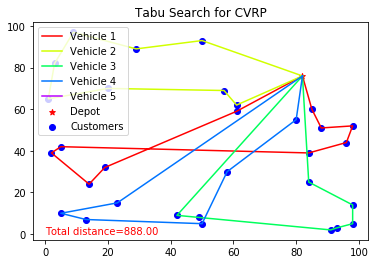

In [5]:
tabu_vrp = Tabu_VRP('data\VRP\A-n32-k5.vrp', n_vehicles=6, initialize='greedy')
tabu_vrp.run()
tabu_vrp.plot()

We see that Tabu search gives a much better result than Greedy search. Also, we notice that initializing Tabu search with the greedy algorithm has a much larger benefit. We compare the benefit for multiple example problems below. More complex problems can be found at [afurculita's repo](https://github.com/afurculita/VehicleRoutingProblem/tree/master/datasets).

In [6]:
problems = ['A-n32-k5', 'A-n33-k6', 'A-n48-k7', 'A-n80-k10', 'B-n56-k7', 'P-n22-k8', 'P-n76-k5']
n_trials = 10
costs = np.empty((len(problems), n_trials, 2))
for p, prob in enumerate(problems):
    print('Solving {}...'.format(prob))
    for i in range(n_trials):
        tabu_vrp = Tabu_VRP('data\VRP\{}.vrp'.format(prob), initialize='random')
        _, cost_random = tabu_vrp.run()
        tabu_vrp = Tabu_VRP('data\VRP\{}.vrp'.format(prob), initialize='greedy')
        _, cost_greedy = tabu_vrp.run()
        costs[p, i, :] = [cost_random, cost_greedy]

Solving A-n32-k5...
Solving A-n33-k6...
Solving A-n48-k7...
Solving A-n80-k10...
Solving B-n56-k7...
Solving P-n22-k8...
Solving P-n76-k5...


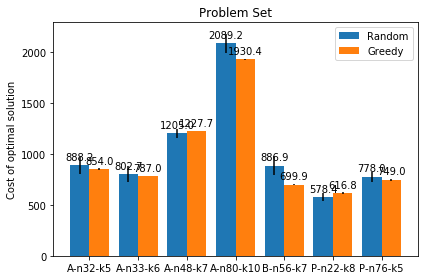

In [11]:
random_means = np.average(costs[:, :, 0], axis=1)
random_std = np.std(costs[:, :, 0], axis=1)
greedy_means = np.average(costs[:, :, 1], axis=1)
greedy_std = np.std(costs[:, :, 1], axis=1)
x = 2*np.arange(len(problems))  # the label locations
width = 0.8  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, random_means, width, yerr=random_std, label='Random')
rects2 = ax.bar(x + width/2, greedy_means, width, yerr=greedy_std, label='Greedy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cost of optimal solution')
ax.set_title('Problem Set')
ax.set_xticks(x)
ax.set_xticklabels(problems)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

We observe that in most cases (except that of `P-n22-k8.vrp`) having a greedy initial solution leads to better optimal solution being found. In all cases, the standard deviation of the optimal solution is much smaller when beggining with the greedy initial solution (as expected, since for every new random initialization, the initialization is different).